# ELEC470 Equalizer Studies
- Modified HWs by Huzeyfe ERKEK
- Source : Rich Kozick, ELEC 470, Spring 1998

In [1]:
#------------------------------------------------------------------------------#
# Adding comm module path
#------------------------------------------------------------------------------#
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#------------------------------------------------------------------------------#
# Import Libraries
#------------------------------------------------------------------------------#
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi
from numpy import exp as exp
from numpy import log as log
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import sign as sign
from numpy import real as real
from numpy import imag as imag

from scipy import signal
from scipy.signal import convolve
from scipy.signal import lfilter
from scipy.signal import filtfilt
from scipy.linalg import toeplitz
from scipy.signal import upfirdn

from utils.utils_filter import *
from utils.utils_waveform import *
from utils.utils_report import *

from adaptive_filters.lms import *
from adaptive_filters.rls import *

from modulation.bpsk_modulator import BpskModulator
from modulation.bpsk_demodulator import BpskDemodulator

## Simulating Communication Link

In [3]:
#------------------------------------------------------------------------------#
# Data Parameters
#------------------------------------------------------------------------------#
T = 1 # Bit period
dt = 0.1 # Sampling time in simulation
nT = int(T/dt) # Samples per symbol
N = 1000 # Number of bits to generate
nx = N*nT # Total samples

#------------------------------------------------------------------------------#
# Channel Parameters
#------------------------------------------------------------------------------#
snr_db = 15
snr = 10**(snr_db/10)
tau = 3 # Time constant of channel
n_isi = 5*tau
nc = nT*(T + n_isi)
c = np.full((nc), 0).reshape(-1).astype(float)

#------------------------------------------------------------------------------#
# Equalizer Parameters
#------------------------------------------------------------------------------#
Ne = int(n_isi/T) # Number of equalizer samples

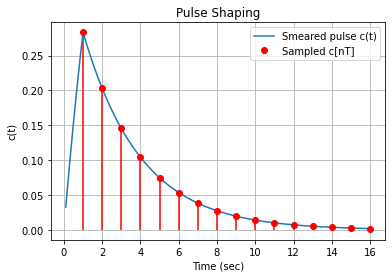

In [4]:
#------------------------------------------------------------------------------#
# Create output pulse: rectangular pulse convolved with first-order low-pass 
# filter impulse response
#------------------------------------------------------------------------------#
# Pulse in symbol period
t1 = np.arange(dt, T+dt, dt)
c[0:nT] = 1 - exp(-t1/tau)

# Interfered part
t2 = np.arange(T+dt, T+n_isi+dt, dt)
c[nT:nT+t2.shape[0]] = c[nT-1]*exp(-(t2-T)/tau)

# Get samples of c(t) to solve for equalizer weights
cT = c[nT-1:nc+nT:nT]

# Plotting
plt.figure()
plt.title('Pulse Shaping')
plt.plot(np.concatenate([t1,t2]), c)
plt.stem(np.arange(nT, nc+nT, nT)*dt, cT, basefmt=" ", linefmt="red", markerfmt="ro")
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('c(t)')
plt.legend(['Smeared pulse c(t)', 'Sampled c[nT]'])
plt.show()

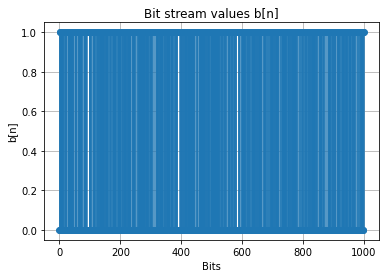

In [5]:
#------------------------------------------------------------------------------#
# Generate bit stream
#------------------------------------------------------------------------------#
bits = np.random.normal(0, 1, N)>0
symbols = 2*bits - 1

# Plotting
plt.figure()
plt.title('Bit stream values b[n]')
plt.stem(bits, basefmt=" ")
plt.grid()
plt.xlabel('Bits')
plt.ylabel('b[n]')
plt.show()

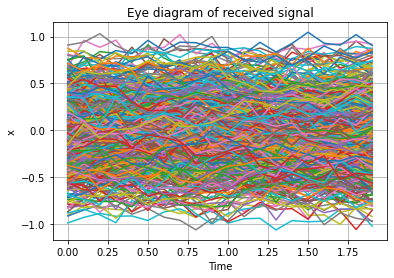

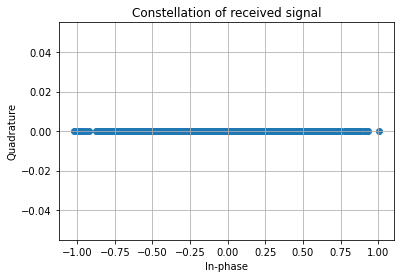

In [6]:
#------------------------------------------------------------------------------#
# Received signal with ISI
#------------------------------------------------------------------------------#
x = upsample(symbols, nT)
x = lfilter(c, 1, x)

# Add noise of the specified level
s_p = power(x) # Signal power
n_p = s_p/snr # Noise power
noise = sqrt(n_p) * np.random.normal(0, 1, x.size)
x +=noise
xT = x[nT-1::nT]

# Plot received signal
plt.figure()
plt.plot(np.arange(0, 2*T, dt), np.transpose(x.reshape(-1, nT*2)))
plt.title('Eye diagram of received signal')
plt.grid()
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

plt.figure()
plt.scatter(real(xT), imag(xT))
plt.title('Constellation of received signal')
plt.grid()
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

## Receiver with Equalization

In [7]:
#------------------------------------------------------------------------------#
# Common Equalization Variables
#------------------------------------------------------------------------------#
# Toeplitz convolution matrix of the channel on the left side of ZF equalizer equation
padding = np.zeros(Ne, cT.dtype)
first_col = np.r_[cT, padding]
first_row = np.r_[[cT[0]], padding, padding]
C = toeplitz(first_col, first_row)

### Zero-Forcing Equalization

ZF Equalizer
Link Report (BPSK):
    SER, 1.0e-3, (1/1000)
    BER, 1.0e-3, (1/1000)
    EVM, 28.87436899047955 [RMS]


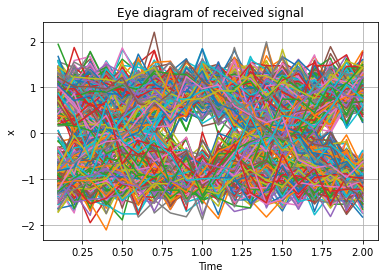

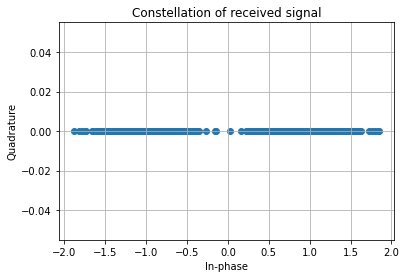

In [8]:
#------------------------------------------------------------------------------#
# ZF Equalization
#------------------------------------------------------------------------------#
# Right side of ZF equalizer weight equation
r = np.r_[padding, [1], padding]

# Solve for ZF equalizer weights
w_zf, resid, rank, s = np.linalg.lstsq(C, r, rcond=-1) # Left matrix division, rcond is about internals of python
h_zf = upsample(w_zf, nT)

# Filter signal
y_zf= filterB(h_zf, x, Ne*nT)
yT_zf = y_zf[nT-1::nT]

print("ZF Equalizer")
linkReport(yT_zf, symbols, BpskDemodulator())

# Plot ZF equalized signal
plt.figure()
plt.plot(np.arange(dt, 2*T+dt, dt), np.transpose(y_zf.reshape(-1, nT*2)))
plt.title('Eye diagram of received signal')
plt.grid()
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

plt.figure()
plt.scatter(real(yT_zf), imag(yT_zf))
plt.title('Constellation of received signal')
plt.grid()
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

### Wiener Equalization

Wiener Equalizer
Link Report (BPSK):
    SER, 0.0e0, (0/1000)
    BER, 0.0e0, (0/1000)
    EVM, 26.85030410817837 [RMS]


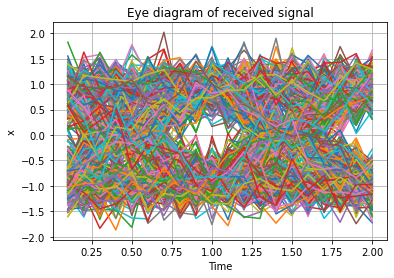

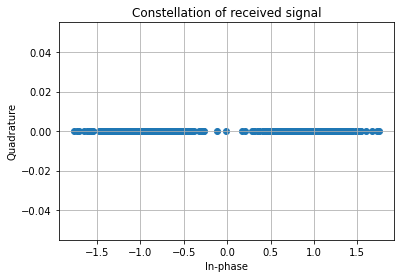

In [9]:
#------------------------------------------------------------------------------#
# Wiener Equalization
#------------------------------------------------------------------------------#
Rxx = np.zeros((2*Ne+1,2*Ne+1))
Rxd = np.zeros(2*Ne+1)
for k in range(Ne,N-Ne):
    xk = xT[(k-Ne):(k+Ne+1)]
    xk_r = np.flipud(xk)
    Rxx = Rxx + xk_r.reshape(-1, 1) @ xk_r.conj().reshape(1, -1)
    Rxd += symbols[k]*xk_r

# Obtain wiener filter coefficients
w_wiener, resid, rank, s = np.linalg.lstsq(Rxx, Rxd.reshape(-1, 1), rcond=-1) # Left matrix division, rcond is about internals of python
h_wiener = upsample(w_wiener, nT)

# Filter signal
y_wiener = filterB(h_wiener, x, nT*Ne)
yT_wiener = y_wiener[nT-1::nT] # Sampling

print("Wiener Equalizer")
linkReport(yT_wiener, symbols, BpskDemodulator())

# Plot Wiener equalized signal
plt.figure()
plt.plot(np.arange(dt, 2*T + dt, dt), np.transpose(y_wiener.reshape(-1, nT*2)))
plt.title('Eye diagram of received signal')
plt.grid()
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

plt.figure()
plt.scatter(real(yT_wiener), imag(yT_wiener))
plt.title('Constellation of received signal')
plt.grid()
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

### Adaptive Linear Equalization with Least Mean Square Algorithm

LMS Equalizer
Link Report (BPSK):
    SER, 0.0e0, (0/1000)
    BER, 0.0e0, (0/1000)
    EVM, 29.107820099120847 [RMS]


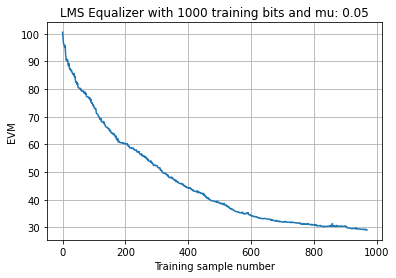

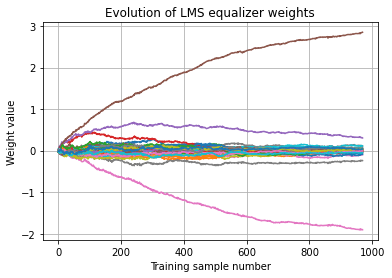

In [10]:
#------------------------------------------------------------------------------#
# Adaptive equalizer with LMS algorithm
#------------------------------------------------------------------------------#
# Memory allocation to record evolution of LMS
wrec = np.zeros((2*Ne+1, N-2*Ne))
evm_lms = np.zeros(N-2*Ne)

# LMS parameters and initial weights
mu_lms = 0.05
w_lms = wrec[:,0].reshape(-1, 1) # Initialize weights to zero

# LMS algorithm to estimate the equalizer weights in real-time using the training data
for k in range(Ne,N-Ne):
    xk = xT[(k-Ne):(k+Ne+1)]
    xk_r = np.flipud(xk).reshape(-1,1)
    yk = np.dot(w_lms.T,xk_r)
    ek = symbols[k] - yk
    w_lms = w_lms + mu_lms*ek*xk_r
    wrec[:, k-Ne] = w_lms.flatten()
    
    # Equalize for each weight to monitor EVM
    yT_k = filterB(w_lms, xT, Ne)
    evm_lms[k-Ne] = errorVectorMagnitude(yT_k, symbols)

yT_lms = filterB(w_lms, xT, Ne)

print("LMS Equalizer")
linkReport(yT_lms, symbols, BpskDemodulator())

# Plot Wiener equalized signal
plt.figure()
plt.plot(evm_lms)
plt.grid()
plt.title('LMS Equalizer with ' + str(N) + ' training bits and mu: ' + str(mu_lms))
plt.xlabel('Training sample number')
plt.ylabel('EVM')

plt.figure()
plt.plot(wrec.T)
plt.grid()
plt.title('Evolution of LMS equalizer weights')
plt.xlabel('Training sample number')
plt.ylabel('Weight value')
plt.show()